In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [88]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [89]:
df = pd.read_csv('forestfires.csv')

In [90]:
cat_col = ['month', 'day']
enc = OneHotEncoder(sparse_output=False)
cat_encoded = enc.fit_transform(df[cat_col])
enc_df = pd.DataFrame(cat_encoded, columns=enc.get_feature_names_out(cat_col))

In [91]:
X = df.drop(['target'] + cat_col, axis=1)
X = pd.concat([X, enc_df], axis=1)
y = df['target']

In [92]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [93]:
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.2, random_state=42)

In [94]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [95]:
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

In [96]:
print("Data Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
 13  target  517 non-null    int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 56.7+ KB
None

Missing Values:
X         0
Y         0
month     0
day       0
FFMC      0
DMC       0
DC        0
ISI       0
temp      0
RH        0
wind      0
rain      0
area      0
target    0
dtype: int64


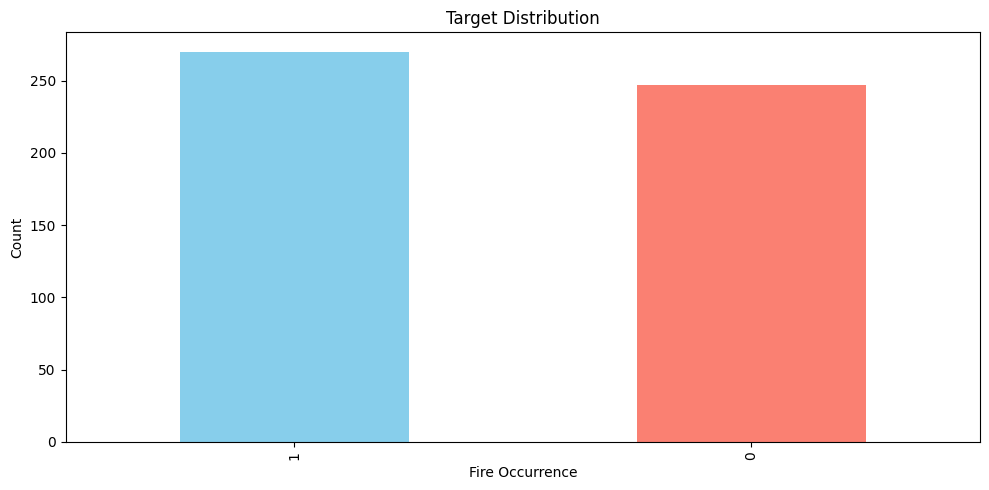

In [97]:
y_pred = model.predict(X_test) 
plt.figure(figsize=(10, 5))
df['target'].value_counts().plot(
    kind='bar', title='Target Distribution', color=['skyblue', 'salmon']
)
plt.xlabel('Fire Occurrence')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "target_distribution.png"))
plt.show()

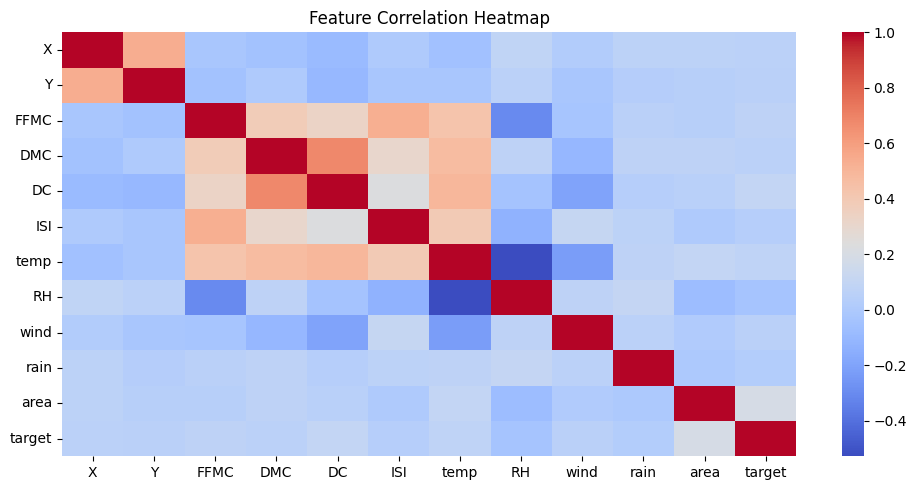

In [98]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 5))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "correlation_heatmap.png"))
plt.show()


Accuracy: 0.769

Confusion Matrix:
 [[44  7]
 [17 36]]


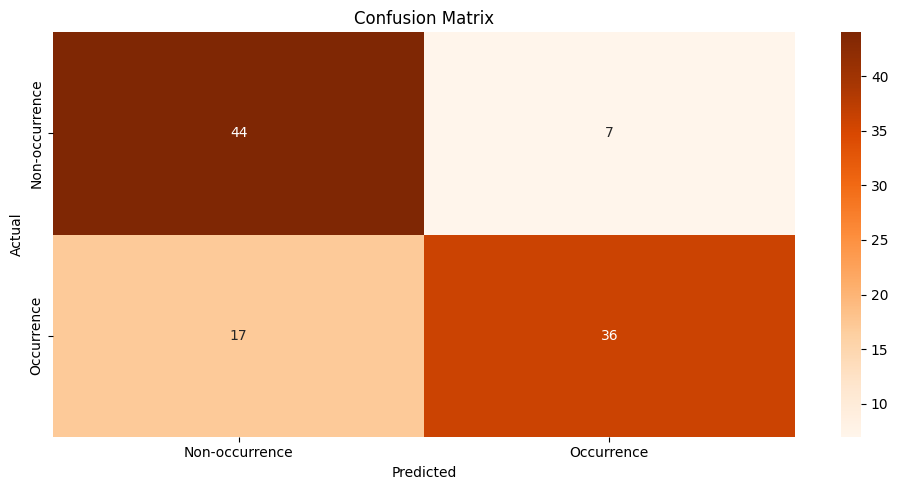


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.79        51
           1       0.84      0.68      0.75        53

    accuracy                           0.77       104
   macro avg       0.78      0.77      0.77       104
weighted avg       0.78      0.77      0.77       104



In [99]:
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.3f}")
coftrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", coftrix)
plt.figure(figsize=(10, 5))
sns.heatmap(
    coftrix, annot=True, fmt='d', cmap='Oranges',
    xticklabels=['Non-occurrence', 'Occurrence'],
    yticklabels=['Non-occurrence', 'Occurrence']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Feature Importance (sorted):
      Feature  Coefficient
10       area     6.098594
13  month_dec     0.529216
4          DC     0.364691
6        temp     0.260745
2        FFMC     0.221152
8        wind     0.154590
14  month_feb     0.138535
7          RH     0.129926
19  month_may     0.128082
0           X     0.106043
28    day_tue     0.101623
1           Y     0.092519
18  month_mar     0.049608
16  month_jul     0.042294
24    day_mon     0.041559
29    day_wed     0.038552
23    day_fri     0.003545
11  month_apr    -0.001575
25    day_sat    -0.002580
17  month_jun    -0.005112
27    day_thu    -0.015752
9        rain    -0.019246
22  month_sep    -0.065034
15  month_jan    -0.081476
12  month_aug    -0.090319
5         ISI    -0.109208
26    day_sun    -0.142259
20  month_nov    -0.172122
3         DMC    -0.181293
21  month_oct    -0.247971


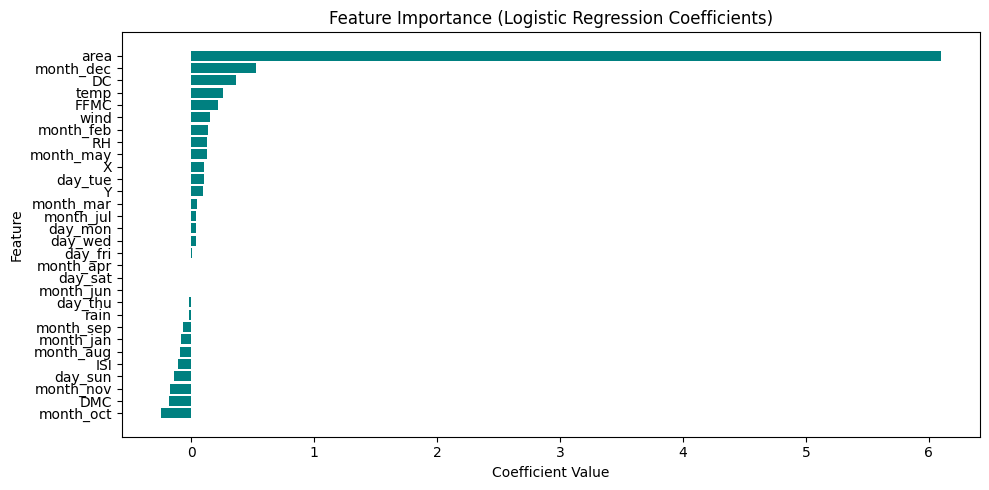

In [100]:
feature_names = X.columns
coefs = model.coef_[0]
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print("\nFeature Importance (sorted):")
print(coef_df)
plt.figure(figsize=(10, 5))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='teal')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_importance.png"))
plt.show()

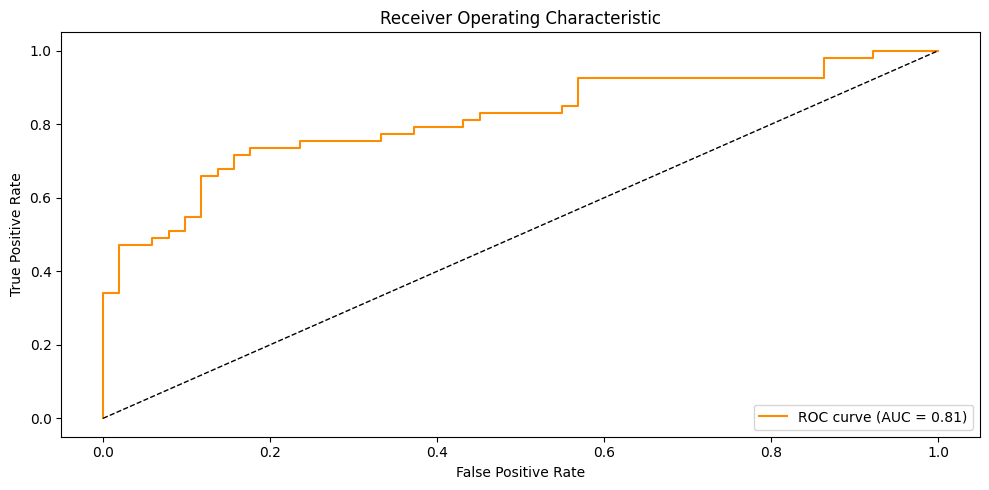

In [101]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "roc_curve.png"))
plt.show()

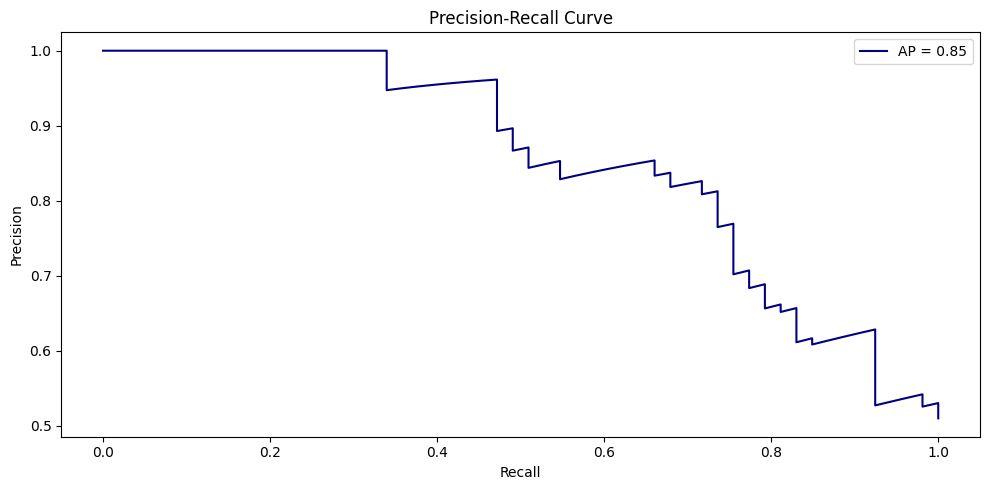

In [102]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, color='navy', label=f'AP = {avg_prec:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "precision_recall_curve.png"))
plt.show()

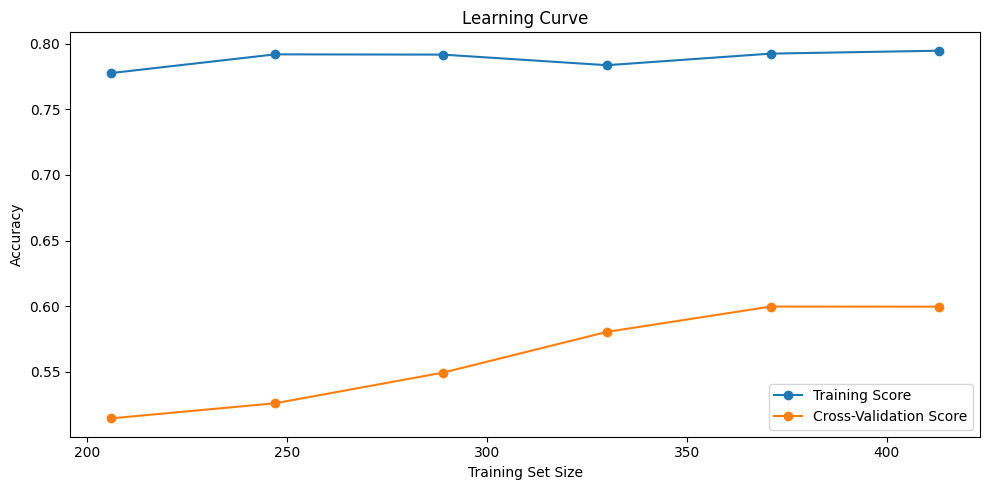

In [103]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.5, 1.0, 6)  # Increased min size to 50%
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "learning_curve.png"))
plt.show()

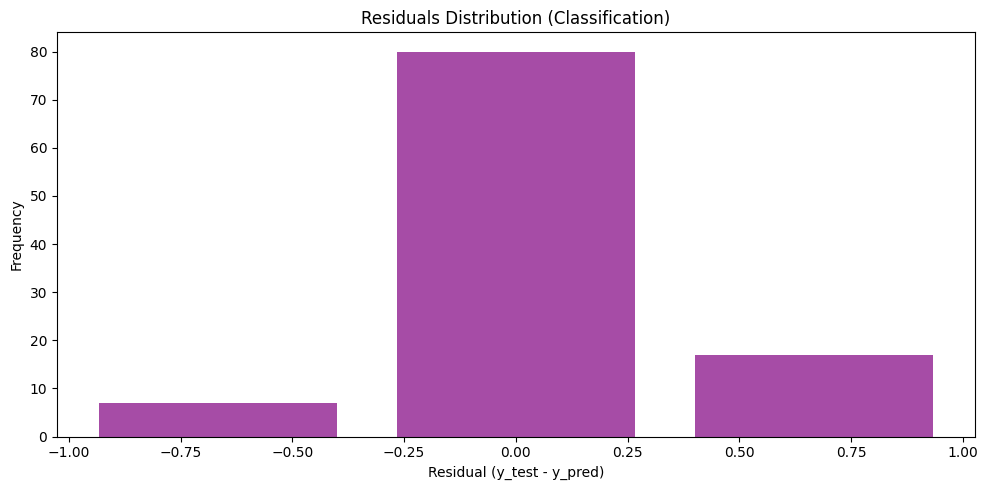

In [104]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=3, color='purple', alpha=0.7, rwidth=0.8)
plt.title('Residuals Distribution (Classification)')
plt.xlabel('Residual (y_test - y_pred)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "residuals_hist.png"))
plt.show()

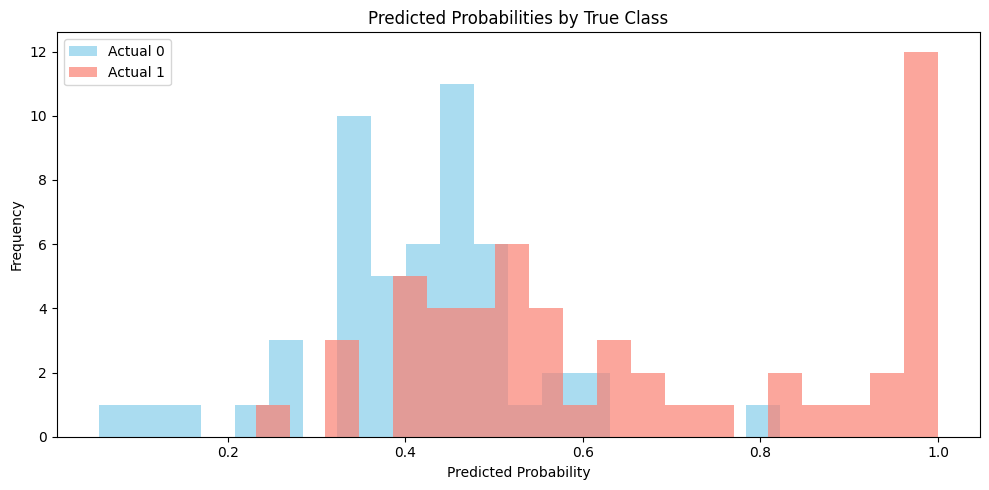

In [105]:
plt.figure(figsize=(10, 5))
plt.hist(y_prob[y_test == 0], bins=20, alpha=0.7, label='Actual 0', color='skyblue')
plt.hist(y_prob[y_test == 1], bins=20, alpha=0.7, label='Actual 1', color='salmon')
plt.title('Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "prob_hist_by_class.png"))
plt.show()